In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns

sns.set_theme()

import sklearn
sklearn.__version__

'1.7.2'

In [2]:
df = pd.read_csv('dataset/full_wage.csv', index_col='Unnamed: 0')
X = df.drop(['WAGE'],axis=1)
display(X.head(3))
y = df['WAGE']

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,19,White,Other,Manufacturing,Unmarried


In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Предобработка числовых переменных.

Сделам сразу предобработку для корректной работы с коэффициентами.

In [4]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

categorical_columns = ["RACE", "OCCUPATION", "SECTOR", "MARR", "UNION", "SEX", "SOUTH"]
numerical_columns =   ["EDUCATION", "EXPERIENCE", "AGE"]

preprocessor = make_column_transformer(
    (OneHotEncoder(drop="if_binary", sparse_output=False), categorical_columns),
    (StandardScaler(), numerical_columns),
    remainder="passthrough",
    verbose_feature_names_out=False,
).set_output(transform="pandas")


In [5]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=1e-10), func=np.log, inverse_func=np.exp
    ),
)

In [6]:
model.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('transformedtargetregressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('onehotencoder', ...), ('standardscaler', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


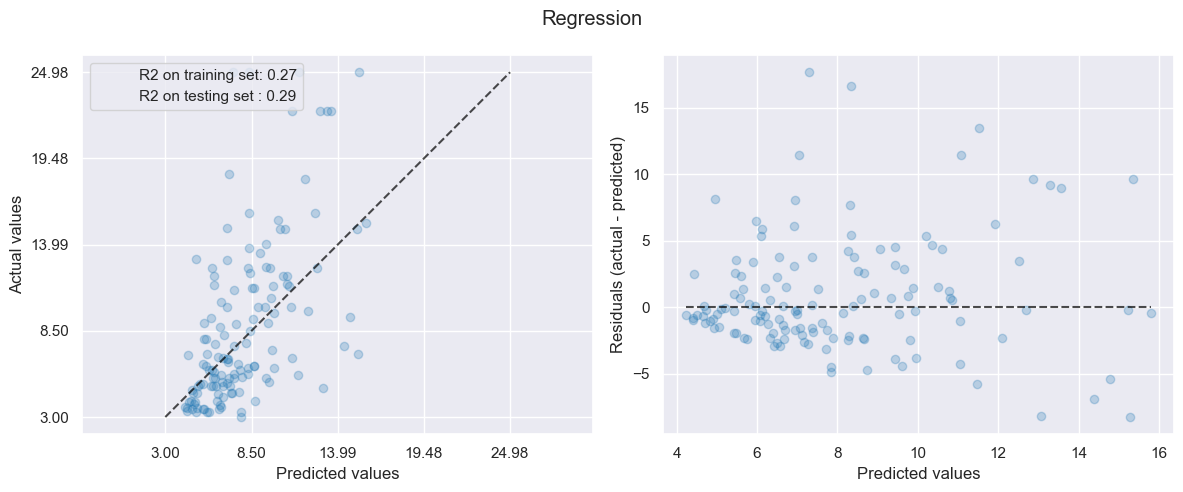

In [7]:
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error

y_pred = model.predict(X_test)
r_train = model.score(X_train,y_train)
r_test = model.score(X_test,y_test)


scores = {
    "R2 on training set": f"{r_train:.2f}",
    "R2 on testing set ": f"{r_test:.2f}",
}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
_ = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=axs[0], scatter_kwargs={"alpha": 0.25}
)
_ = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="residual_vs_predicted", ax=axs[1], scatter_kwargs={"alpha": 0.25}
)


fig.suptitle("Regression")

for name, score in scores.items():
    axs[0].plot([], [], " ", label=f"{name}: {score}")
axs[0].legend(loc="upper left")
plt.tight_layout()

In [8]:
feature_names = model[:-1].get_feature_names_out()

coefs = pd.DataFrame(
    {"Coefficients": model[-1].regressor_.coef_, 
     'Std': model[:-1].transform(X_train).std(axis=0).values},
     index=feature_names    
)

coefs

,Coefficients,Std
RACE_Hispanic,-0.031156,0.223312
RACE_Other,-0.020924,0.336725
RACE_White,0.051998,0.386740
OCCUPATION_Clerical,0.000284,0.398611
OCCUPATION_Management,0.208627,0.319421
OCCUPATION_Other,-0.057619,0.449561
OCCUPATION_Professional,0.165882,0.396697
OCCUPATION_Sales,-0.107204,0.246835
OCCUPATION_Service,-0.209478,0.355048
SECTOR_Construction,-0.000481,0.212972


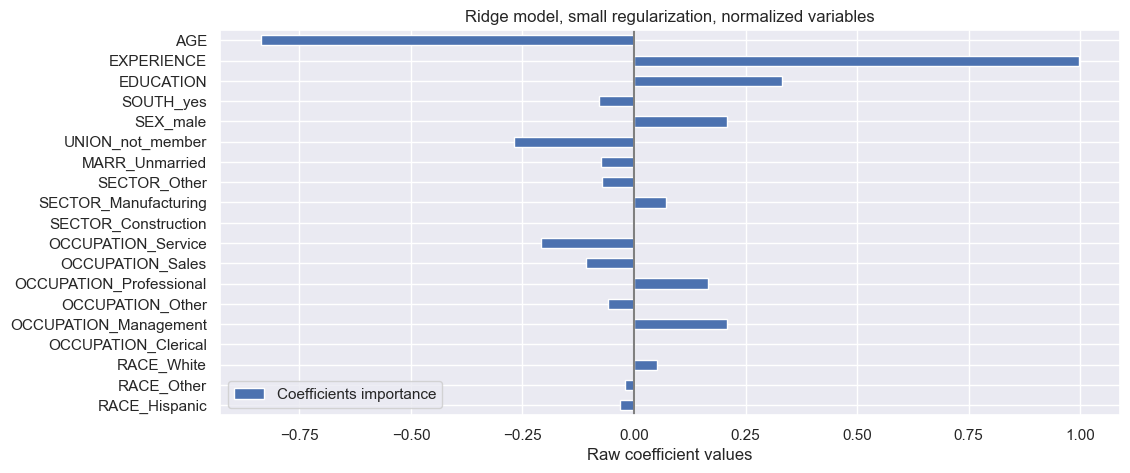

In [9]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot.barh(figsize=(15, 5))
plt.title("Ridge model, small regularization, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

In [10]:
from sklearn.model_selection import RepeatedKFold, cross_validate

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
    [est[-1].regressor_.coef_ for est in cv_model["estimator"]], columns=feature_names
)

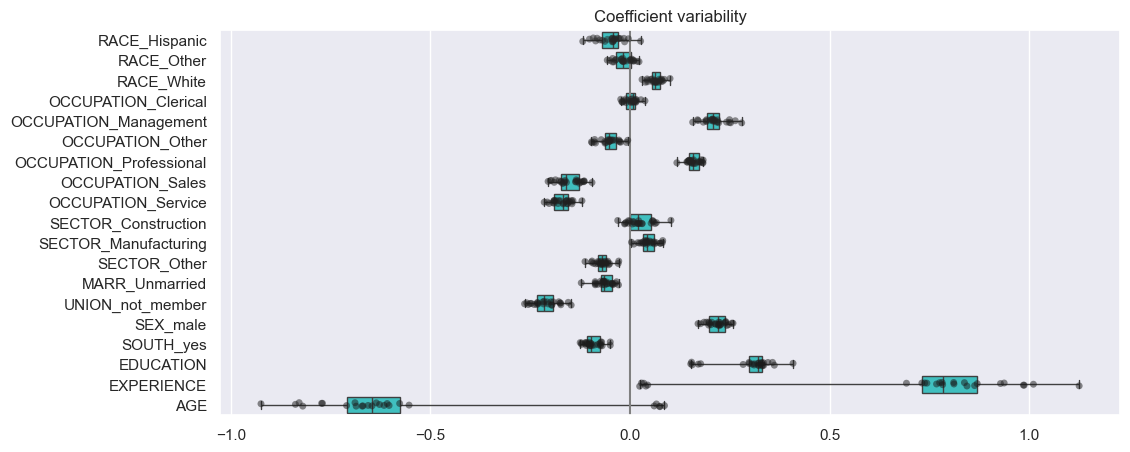

In [11]:
plt.figure(figsize=(15, 5))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability")
plt.subplots_adjust(left=0.3)

Результат из-за мультикорреляции похож на предидущий ненормализованный случай.

## Регуляризация линейных моделей

В машинном обучении регрессия `Ridge` чаще используется с регуляризацией, которое имеет достаточно значимое значение.

Ранее регуляризация, в нашем примере, практически отсутствовала. Регуляризация улучшает условия задачи и уменьшает дисперсию оценок. `Ridge CV` применяет перекрестную проверку, чтобы подобрать значение параметра регуляризации (`alpha`), что бы улучшить качество модели.

In [12]:
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-10, 15, 26)  # перебор alpha на валидации
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(alphas=alphas),
        func=np.log10,
        inverse_func=sp.special.exp10,
    ),
)
model.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('transformedtargetregressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('onehotencoder', ...), ('standardscaler', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [13]:
model[-1].regressor_.alpha_

10.0

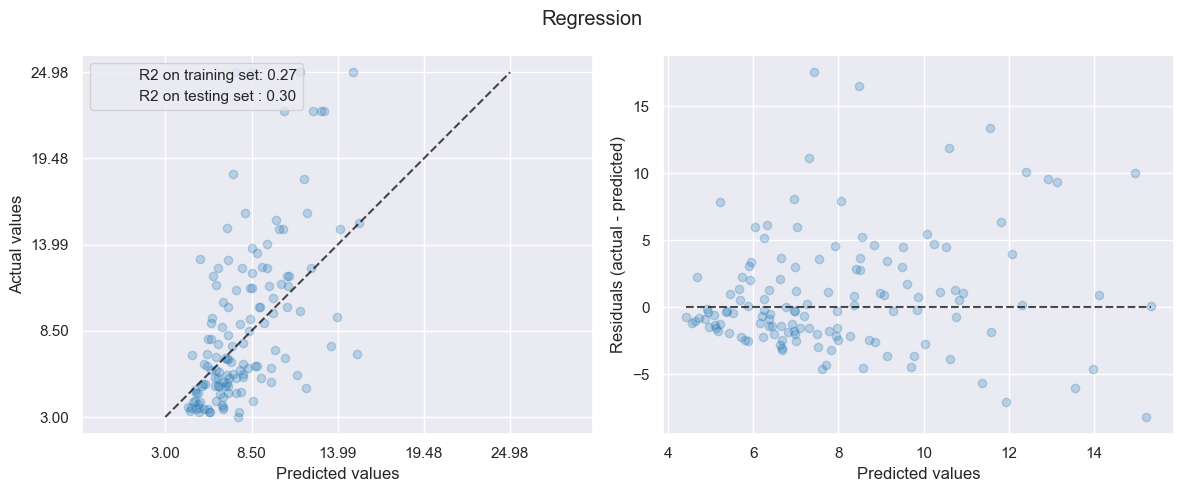

In [14]:
y_pred = model.predict(X_test)
r_train = model.score(X_train,y_train)
r_test = model.score(X_test,y_test)


scores = {
    "R2 on training set": f"{r_train:.2f}",
    "R2 on testing set ": f"{r_test:.2f}",
}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
_ = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=axs[0], scatter_kwargs={"alpha": 0.25}
)
_ = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="residual_vs_predicted", ax=axs[1], scatter_kwargs={"alpha": 0.25}
)


fig.suptitle("Regression")

for name, score in scores.items():
    axs[0].plot([], [], " ", label=f"{name}: {score}")
axs[0].legend(loc="upper left")
plt.tight_layout()

Способность регуляризованной модели к предсказанию несколько лучше способности нерегуляризованной модели.

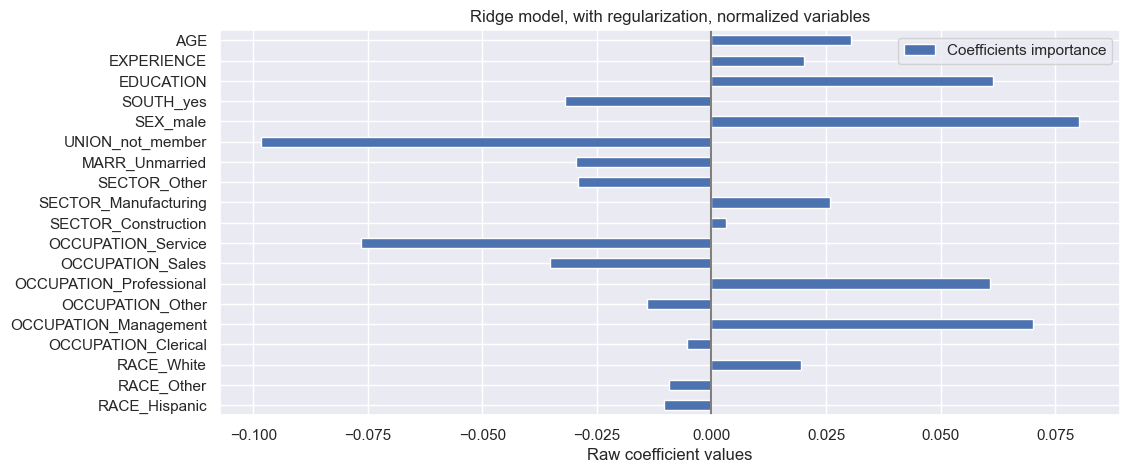

In [15]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot.barh(figsize=(15, 5))
plt.title("Ridge model, with regularization, normalized variables")
plt.xlabel("Raw coefficient values")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

Коэффициенты существенно отличаются. 

Коэффициенты AGE и EXPERIENCE являются положительными, но теперь они оказывают меньшее влияние на прогноз.

Регуляризация уменьшает влияние коррелирующих переменных на модель, поскольку вес распределяется между двумя прогностическими переменными, поэтому ни одна из них по отдельности не будет иметь большого веса.

С другой стороны, веса, полученные с помощью регуляризации, более стабильны. Эта стабильность видна из графика, полученного на основе анализа стандартных отклонений при перекрестной проверке. Этот график можно сравнить с предыдущим.

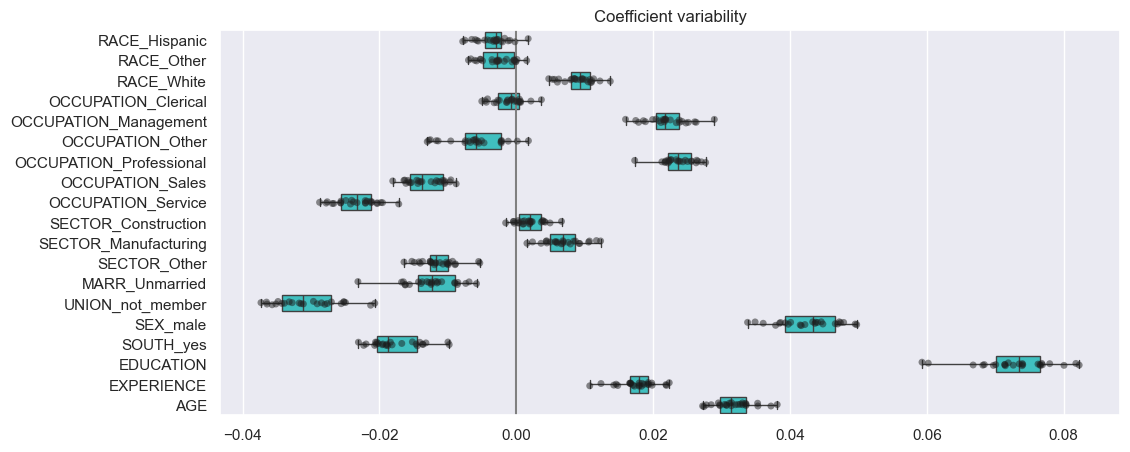

In [16]:
from sklearn.model_selection import RepeatedKFold, cross_validate

cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
        [est[-1].regressor_.coef_ * est[:-1].transform(X.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X, y))]
    , columns=feature_names
)

plt.figure(figsize=(15, 5))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability")
plt.subplots_adjust(left=0.3)

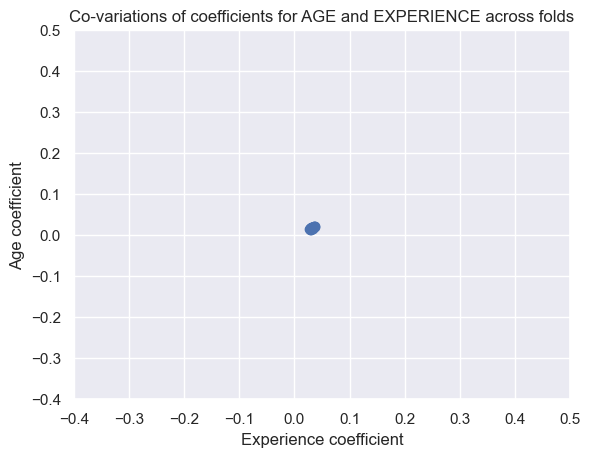

In [17]:
plt.ylabel("Age coefficient")
plt.xlabel("Experience coefficient")
plt.grid(True)
plt.xlim(-0.4, 0.5)
plt.ylim(-0.4, 0.5)
plt.scatter(coefs["AGE"], coefs["EXPERIENCE"])
_ = plt.title("Co-variations of coefficients for AGE and EXPERIENCE across folds")

## Линейные модели с разреженными коэффициентами

Другой возможностью учесть коррелированные переменные в наборе данных является оценка разреженных коэффициентов. В некотором роде мы уже делали это вручную, когда удаляли столбец ВОЗРАСТА в предыдущей оценке гребневой регресии.

In [18]:
from sklearn.linear_model import LassoCV

alphas = np.logspace(-10, 15, 26)  # alpha values to be chosen from by cross-validation
model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LassoCV(alphas=alphas, max_iter=100_000),
        func=np.log10,
        inverse_func=sp.special.exp10,
    ),
)

model.fit(X_train, y_train)

,steps,"[('columntransformer', ...), ('transformedtargetregressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('onehotencoder', ...), ('standardscaler', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [19]:
model[-1].regressor_.alpha_

0.001

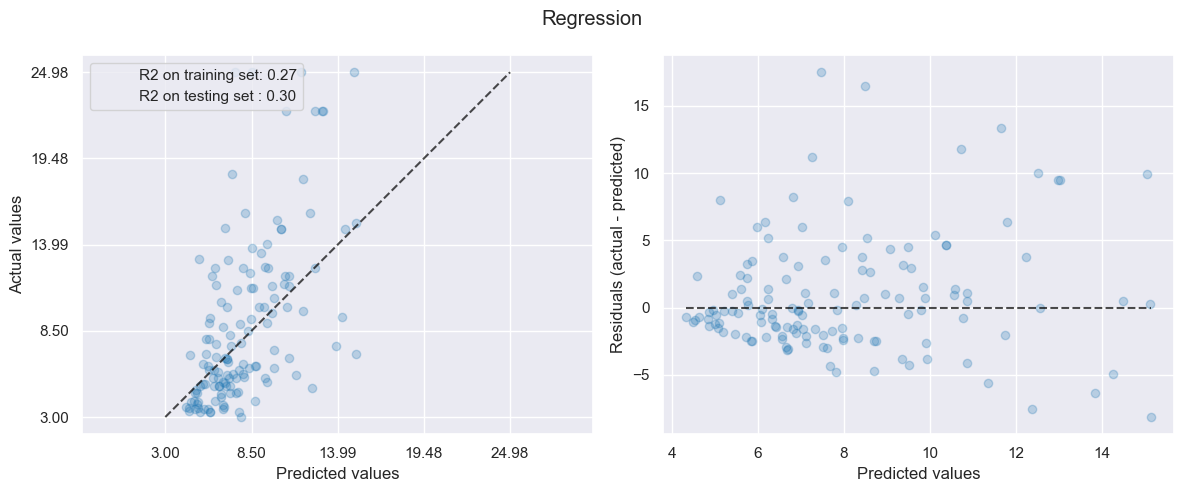

In [20]:
y_pred = model.predict(X_test)
r_train = model.score(X_train,y_train)
r_test = model.score(X_test,y_test)


scores = {
    "R2 on training set": f"{r_train:.2f}",
    "R2 on testing set ": f"{r_test:.2f}",
}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
_ = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=axs[0], scatter_kwargs={"alpha": 0.25}
)
_ = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="residual_vs_predicted", ax=axs[1], scatter_kwargs={"alpha": 0.25}
)


fig.suptitle("Regression")

for name, score in scores.items():
    axs[0].plot([], [], " ", label=f"{name}: {score}")
axs[0].legend(loc="upper left")
plt.tight_layout()

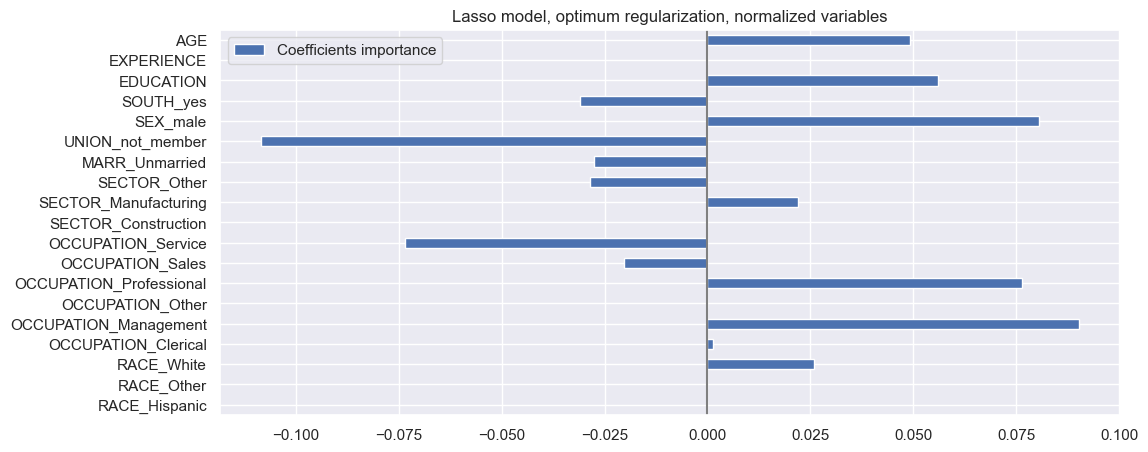

In [21]:
coefs = pd.DataFrame(
    model[-1].regressor_.coef_,
    columns=["Coefficients importance"],
    index=feature_names,
)
coefs.plot(kind="barh", figsize=(15, 5))
plt.title("Lasso model, optimum regularization, normalized variables")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)

Модель Lasso определяет корреляцию между AGE и EXPERIENCE и подавляет один из них для получения прогноза.

Важно иметь в виду, что коэффициенты, которые были отброшены, все еще могут быть связаны с результатом сами по себе: модель решила исключить их, поскольку они не дают дополнительной информации в дополнение к другим характеристикам. 

***Кроме того, этот выбор нестабилен для коррелирующих признаков, и его следует интерпретировать с осторожностью.***

Действительно, мы можем проверить разброс коэффициентов для разных признаков.

In [22]:
cv_model = cross_validate(
    model,
    X,
    y,
    cv=cv,
    return_estimator=True,
    n_jobs=2,
)
coefs = pd.DataFrame(
        [est[-1].regressor_.coef_ * est[:-1].transform(X.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X, y))]
    , columns=feature_names
)

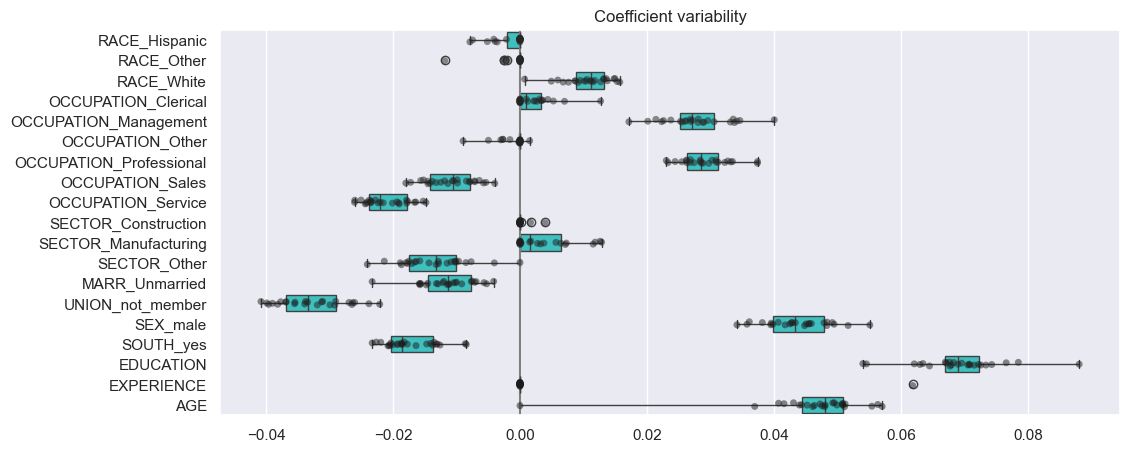

In [23]:
plt.figure(figsize=(15, 5))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=100)
plt.axvline(x=0, color=".5")
plt.title("Coefficient variability")
plt.subplots_adjust(left=0.3)